### Imports

In [182]:
# -------------------------------------------
# Imports & notebook housekeeping
# -------------------------------------------

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------
from datetime import datetime
import itertools
import calendar as cal                   # weekday / month names
import scipy.stats as stats              # normality, skew, etc.
from scipy import stats as sc_stats


# -------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb                   # gradient boosting (fast baseline)
import xgboost as xgb                    # alternative GBM
# import prophet                          # uncomment if you want fbprophet
import statsmodels.api as sm            # ARIMA, ETS, SARIMAX, etc.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss


# -------------------------------------------
import plotly.express as px              # interactive EDA
import plotly.graph_objects as go

# -------------------------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)

# -------------------------------------------
# Nice-to-have settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")          # comment out if you prefer default
# # keep this line by itself if you want explicit inline plotting
# %matplotlib inline

# -------------------------------------------
# Wider, higher-res plots for Matplotlib
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 110

### File allocation and download

In [183]:
# -------------------------------------------
# File locations
# -------------------------------------------]

DATA_PATH = Path("data")            # adjust if our folder is elsewhere

train_path      = DATA_PATH / "train.csv"
calendar_path   = DATA_PATH / "calendar_events.csv"
submission_path = DATA_PATH / "forecast_submission.csv"

### Loading the existing data

In [208]:
# -------------------------------------------
# Load raw CSVs
# -------------------------------------------
train_df    = pd.read_csv(train_path,    parse_dates=["date"])
calendar_df = pd.read_csv(calendar_path, parse_dates=["date"])
test_df     = pd.read_csv(submission_path)   # 'id' encodes date

# Deduplicate (defensive; raw file *should* be clean)
dup_cnt = train_df.duplicated(subset=["store_id", "date"]).sum()
if dup_cnt:
    print(f"⚠️  Found {dup_cnt:,} duplicate store-day rows – aggregating.")
    train_df = (train_df
                .groupby(["store_id", "date"], as_index=False, sort=True)
                .agg({"revenue": "sum"}))

print("Train shape after dedup :", train_df.shape)
display(train_df)
display(calendar_df)
display(test_df)


# -------------------------------------------
# Merge calendar ‘event’ + helper columns
# -------------------------------------------
full_df = (
    train_df.merge(calendar_df, on="date", how="left")      # adds `event`
            .assign(
                dow         = lambda d: d.date.dt.dayofweek,   # 0=Mon … 6=Sun
                month       = lambda d: d.date.dt.month,
                is_zero_day = lambda d: (d.revenue == 0).astype(int)
            )
)

# -------------------------------------------
# Build ±3-day window flags (wide pivot, NO extra rows)
# -------------------------------------------
# create lead/lag columns in the calendar table
cal_shift = calendar_df.copy()
for k in range(1, 4):
    cal_shift[f'event_lead{k}'] = cal_shift['event'].shift(-k)   # k days BEFORE
    cal_shift[f'event_lag{k}']  = cal_shift['event'].shift( k)   # k days AFTER

# pivot so each offset is its own column -> still 1 row per date
lead_lag_cols = [c for c in cal_shift.columns if 'lead' in c or 'lag' in c]
cal_wide = cal_shift[['date'] + lead_lag_cols]

# merge (still one row per date)
full_df = full_df.merge(cal_wide, on="date", how="left")

print("Full DF shape :", full_df.shape)        # should still be 18 766 × (…)
print("Unique (store,date) pairs:", full_df[['store_id','date']].duplicated().sum())
display(full_df)


# -------------------------------------------
# Persist snapshot for all downstream work
# -------------------------------------------
out_path = DATA_PATH / "full_train.pkl"
full_df.to_pickle(out_path)
print(f"✅  Saved merged & enriched train to {out_path}")

Train shape after dedup : (18766, 4)


,store_id,store_name,date,revenue
0,0,All Stores,2011-01-29,204126.52
1,0,All Stores,2011-01-30,197426.42
2,0,All Stores,2011-01-31,144267.27
3,0,All Stores,2011-02-01,151903.00
4,0,All Stores,2011-02-02,117399.88
...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95


,date,event
0,2011-02-06,SuperBowl
1,2011-02-14,ValentinesDay
2,2011-02-21,PresidentsDay
3,2011-03-09,LentStart
4,2011-03-16,LentWeek2
...,...,...
157,2016-05-08,Mother's day
158,2016-05-30,MemorialDay
159,2016-06-02,NBAFinalsStart
160,2016-06-07,Ramadan starts


,id,prediction
0,0_20151001,0
1,0_20151002,0
2,0_20151003,0
3,0_20151004,0
4,0_20151005,0
...,...,...
1007,10_20151227,0
1008,10_20151228,0
1009,10_20151229,0
1010,10_20151230,0


Full DF shape : (18766, 14)
Unique (store,date) pairs: 0


,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_lead1,event_lag1,event_lead2,event_lag2,event_lead3,event_lag3
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55,NaN,5,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53,NaN,6,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53,NaN,0,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95,NaN,1,9,0,NaN,NaN,NaN,NaN,NaN,NaN


✅  Saved merged & enriched train to data/full_train.pkl


In [186]:
# Helper function to make a Kaggle submission file
def make_submission(preds, template_path="data/forecast_submission.csv",
                    out_path="my_submission.csv"):
    """
    Put predictions into exact Kaggle format and save the CSV.
    Assumes `preds` are in the **same order** as rows in the template.
    """
    template = pd.read_csv(template_path)
    if len(preds) != len(template):
        raise ValueError(f"Row-count mismatch: {len(preds)=}, "
                         f"{len(template)=}")
    sub = template.copy()
    sub["prediction"] = np.asarray(preds).ravel()
    sub.to_csv(out_path, index=False)
    print(f"✅  Saved {out_path}  ({len(sub):,} rows)")
    return sub

### Understand the Data & Hierarchy

In [187]:
# unique store ids
print("Store IDs:", sorted(train_df.store_id.unique()))

Store IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [188]:
# aggregate consistency check (check if all stores revenues are correct according to the sum of all independent stores)
total_vs_sum = (
    train_df.query("store_id == 0")
            .set_index("date")["revenue"]
    - train_df.query("store_id != 0")
             .groupby("date")["revenue"].sum()
)
print("Max absolute diff agg vs sum:", total_vs_sum.abs().max())

Max absolute diff agg vs sum: 0.03999999997904524


In [189]:
# date continuity gaps (checks for missing dates in each store)
gaps = {}
for sid, grp in train_df.groupby("store_id"):
    # focus on the revenue Series only
    has_gap = (
        grp.set_index("date")["revenue"]   # <-- pick the column
           .asfreq("D")
           .isna()
           .any()                          # now a single bool
    )
    if has_gap:
        gaps[sid] = grp

print("Stores with gaps:", list(gaps.keys()))

Stores with gaps: []


In [190]:
# number of days with exact 0 revenue
zero_ratio = (
    train_df.assign(is_zero = lambda d: d.revenue == 0)
            .groupby("store_id").is_zero.mean()
            .mul(100).round(2)
)
display(zero_ratio.to_frame("pct_zero_days"))

,pct_zero_days
store_id,
0,0.00
1,0.23
2,0.00
3,0.06
4,0.23
5,0.18
6,0.12
7,0.00
8,0.18


In [191]:
# check when each store start and end date
span = train_df.groupby("store_id").date.agg(['min','max'])
display(span)

,min,max
store_id,,
0,2011-01-29,2015-09-30
1,2011-01-29,2015-09-30
2,2011-01-29,2015-09-30
3,2011-01-29,2015-09-30
4,2011-01-29,2015-09-30
5,2011-01-29,2015-09-30
6,2011-01-29,2015-09-30
7,2011-01-29,2015-09-30
8,2011-01-29,2015-09-30


In [192]:
# Leap-year row check
for sid in full_df.store_id.unique():
    assert pd.Timestamp('2012-02-29') in full_df.query("store_id==@sid").date.values

### Data exploration

####  Daily revenue lines, faceted by store_id

**Take-aways**

Trend: every store shows a roughly monotonic rise—good evidence of macro growth.

Weekly pulses: the saw-tooth pattern hints at a strong weekday/weekend cycle.

Data gaps/outliers: vertical drops to (almost) zero on identical dates across stores—likely system outages or missing-data days; we should flag or impute them.

Scale differences: store 0 dwarfs the others, confirming it’s the aggregate series (see Q&A at bottom).


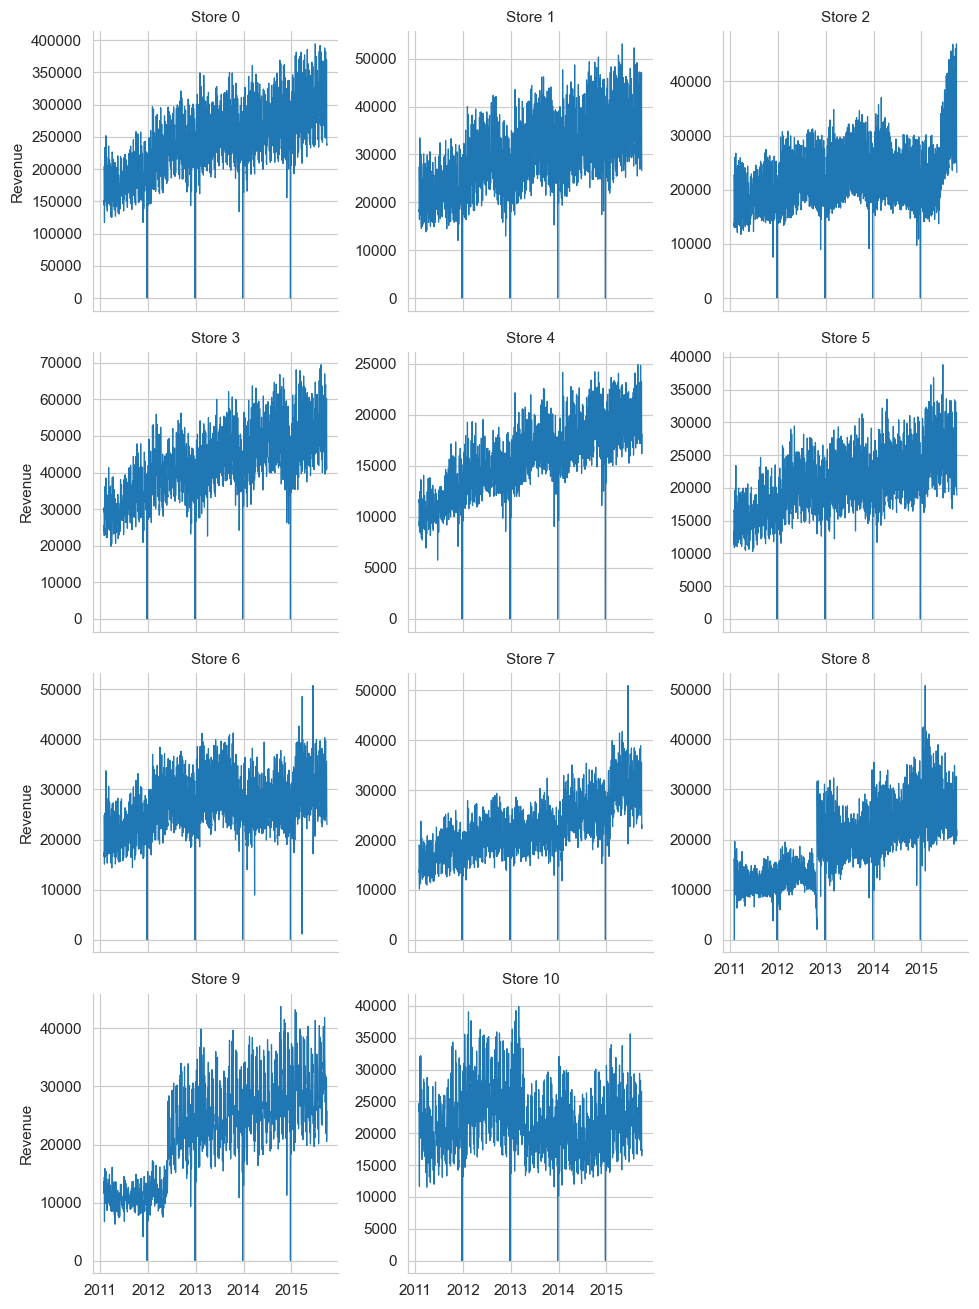

In [193]:
# -----------------------------------------------------------
# Daily revenue lines, faceted by store_id
# -----------------------------------------------------------

g = sns.FacetGrid(
    data=train_df,
    col="store_id",
    col_wrap=3,        # 3 columns per row
    height=3,
    sharey=False
)
g.map_dataframe(sns.lineplot, x="date", y="revenue", lw=0.8)
g.set_titles("Store {col_name}")
g.set_axis_labels("", "Revenue")
plt.tight_layout()
plt.show()

#### 30-day moving average vs. raw daily series (example: store 0)

**Take-aways**

* needs to expect all the stores to be present, not just store 0

Structural trend: 30-day MA climbs from ~180 k → 310 k, confirming long-term growth.

Seasonal bumps: gentle yearly waves (likely Q4 holiday lift).

Extreme troughs: the periodic near-zero spikes match the outages seen above—helps decide outlier handling.


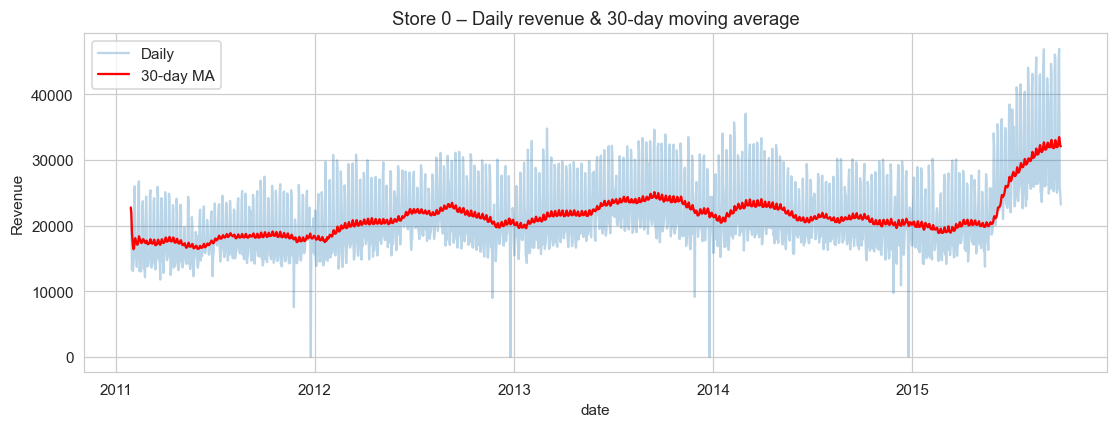

In [194]:
# -----------------------------------------------------------
# Moving average overlay for the "all-stores" series (store_id 0)
# -----------------------------------------------------------
store0 = (
    train_df.loc[train_df.store_id == 2]
            .sort_values("date")
            .assign(ma_30=lambda d: d.revenue.rolling(30, min_periods=1).mean())
)

plt.figure(figsize=(12,4))
sns.lineplot(data=store0, x="date", y="revenue", alpha=0.3, label="Daily")
sns.lineplot(data=store0, x="date", y="ma_30",        color="red", label="30-day MA")
plt.title("Store 0 – Daily revenue & 30-day moving average")
plt.ylabel("Revenue")
plt.show()

#### Weekday pattern (all stores combined)

**Take-aways**

Weekend premium: Sat/Sun medians roughly 25 % higher than mid-week.

Friday build-up: Friday sits between weekdays and weekends—useful for lag features.

Monday rebound: Monday median still higher than Tue–Thu—interesting after-weekend catch-up.

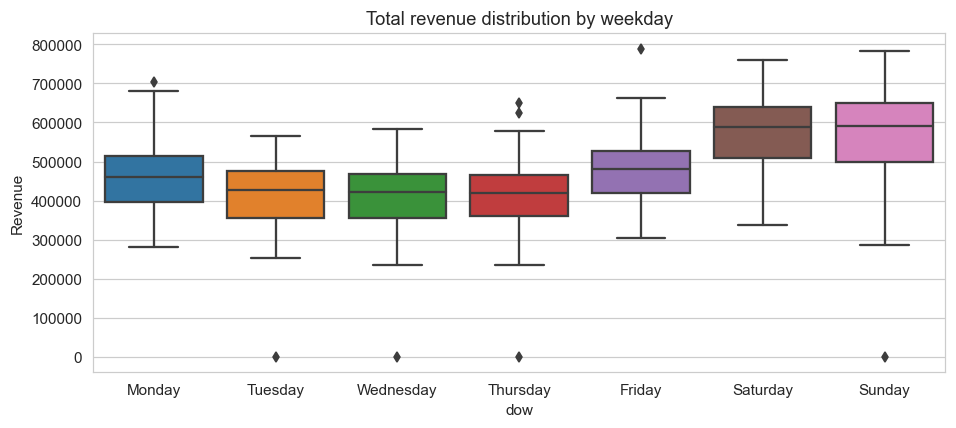

In [195]:
# -----------------------------------------------------------
# Box-plot by day-of-week
# -----------------------------------------------------------
weekday_df = (
    train_df.assign(dow=train_df.date.dt.day_name())
            .groupby(["dow", "date"]).revenue.sum().reset_index()  # total across stores
)
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.figure(figsize=(10,4))
sns.boxplot(data=weekday_df, x="dow", y="revenue", order=order)
plt.title("Total revenue distribution by weekday")
plt.ylabel("Revenue")
plt.show()

#### Month-over-month total revenue (stacked by store)

**Take-aways**

Growth slope: aggregate monthly revenue ~doubles over 5 years, confirms non-stationarity.

Store mix stability: colour bands keep their thickness ~constant → stores grow proportionally; no single store overtakes others (apart from store 0’s built-in dominance).

Holiday peak: one large spike Q4-2013; cross-check with calendar_events.


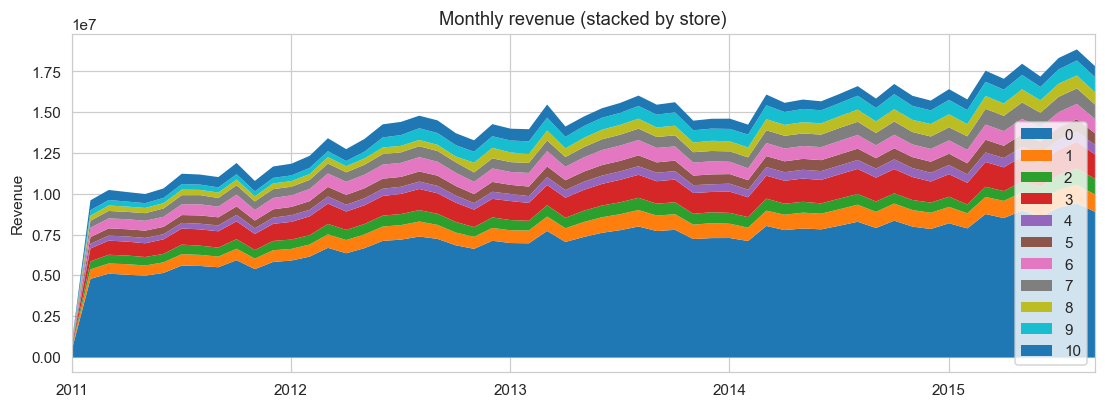

In [196]:
# -----------------------------------------------------------
# Monthly totals pivoted wide → stacked area chart
# -----------------------------------------------------------
monthly_totals = (
    train_df.assign(ym=train_df.date.dt.to_period("M"))
            .groupby(["ym", "store_id"]).revenue.sum()
            .unstack("store_id")
            .rename_axis(index=None, columns=None)
)
monthly_totals.index = monthly_totals.index.to_timestamp()  # Period → Timestamp

monthly_totals.plot.area(figsize=(12,4), stacked=True, linewidth=0)
plt.title("Monthly revenue (stacked by store)")
plt.ylabel("Revenue")
plt.show()

#### Holiday / special-event impact scatter

**Take-aways**

* not too understandable plot needs to be addapted

Positive lift: most coloured markers sit high above the daily baseline—events ≈ sales boosters.

Event variance: some events cluster lower, meaning not every holiday helps (e.g., minor state holidays).

Missing labels: a few natural peaks lack an event tag—maybe promo periods worth creating custom flags for (e.g., “Back-to-School” week).


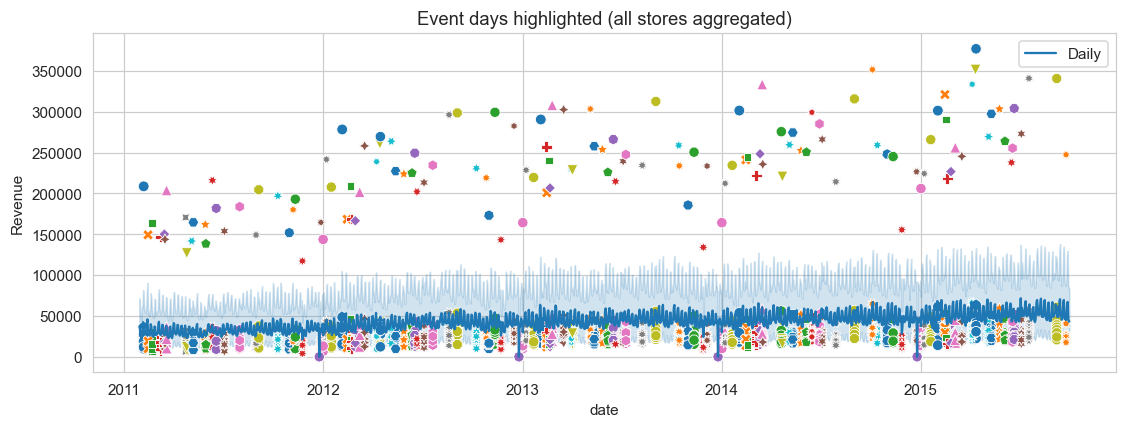

In [197]:
# -----------------------------------------------------------
# Overlay known events on the daily series
# -----------------------------------------------------------
# Merge event labels onto train_df
events = calendar_df.rename(columns={"event": "event_name"})
tmp = train_df.merge(events, on="date", how="left")

plt.figure(figsize=(12,4))
sns.lineplot(data=tmp, x="date", y="revenue", label="Daily")
sns.scatterplot(
    data=tmp[tmp.event_name.notna()],
    x="date", y="revenue",
    hue="event_name", style="event_name",
    palette="tab10", legend=False, s=50
)
plt.title("Event days highlighted (all stores aggregated)")
plt.ylabel("Revenue")
plt.show()

### Uplift bar chart – How much does each event lift sales overall?

**take aways:**
- Only a handful of holidays generate > 5 k lift in the aggregate series.
→ worth creating explicit binary features (is_superbowl, is_easter_week, …).
- Religious holidays (Easter variants, Eid, Ramadan) and U.S. social events (Super Bowl, Father’s Day) dominate; Independence Day is not top-15—interesting anomaly to double-check.
- Since values are absolute dollar, the effect on individual stores will be smaller; we need a per-store view.

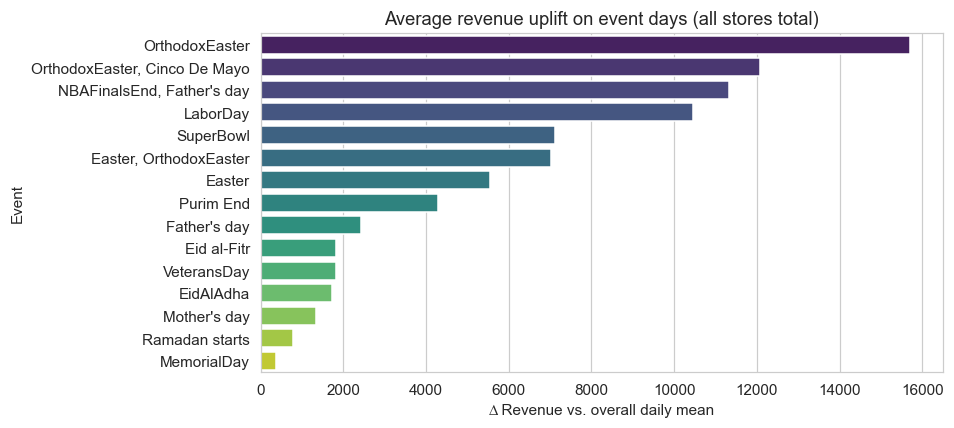

In [198]:
# -----------------------------------------------------------
# 1. Compute uplift = event_day_mean - non_event_mean
# -----------------------------------------------------------
df = train_df.merge(calendar_df, on="date", how="left")

overall_mean = df["revenue"].mean()

uplift = (
    df.groupby("event")["revenue"]
      .mean()
      .sub(overall_mean)             # absolute difference
      .sort_values(ascending=False)
      .head(15)                      # top 15 events
)

# -----------------------------------------------------------
# 2. Plot
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(y=uplift.index, x=uplift.values, palette="viridis")
plt.title("Average revenue uplift on event days (all stores total)")
plt.xlabel("∆ Revenue vs. overall daily mean")
plt.ylabel("Event")
plt.show()

### “Per-store heat-map” – Which stores benefit from which events?

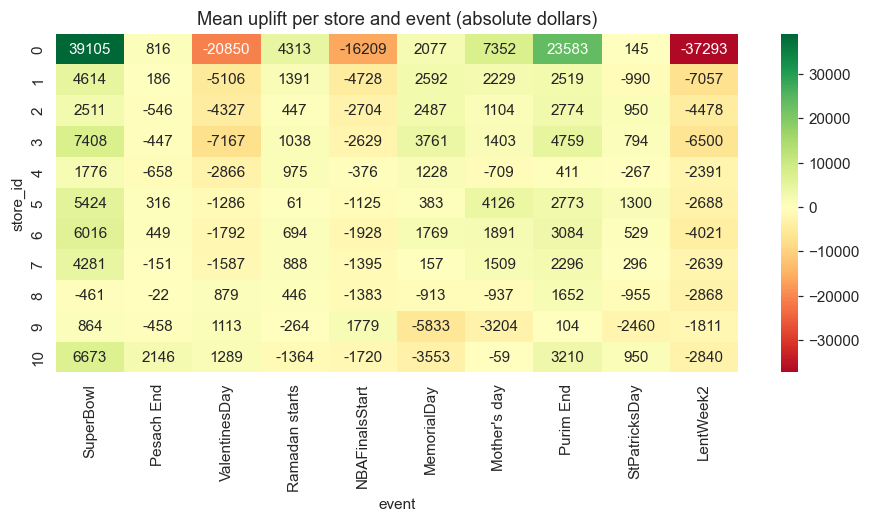

In [199]:
# -----------------------------------------------------------
# 1. Build a pivot table: store_id × event_name
# -----------------------------------------------------------
pivot = (
    df.groupby(["store_id", "event"])["revenue"]
      .mean()
      .unstack("event")                          # columns = events
      .sub(df.groupby("store_id")["revenue"].mean(), axis=0)  # centre per-store
)

# -----------------------------------------------------------
#2. Keep most frequent events to avoid giant table
# -----------------------------------------------------------
top_events = (
    calendar_df["event"]
      .value_counts()
      .head(10)                # pick 10 busiest holidays
      .index
)
pivot = pivot[top_events]

# -----------------------------------------------------------
# 3. Plot heat-map
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap="RdYlGn", center=0, annot=True, fmt=".0f")
plt.title("Mean uplift per store and event (absolute dollars)")
plt.ylabel("store_id")
plt.show()

### Simple outlier screen (per-store whiskers)

**Take-aways**


Scale heterogeneity: store 0 median ≈ 250 k, others 20–60 k → models need either per-store scaling or loss weighting.

Outliers: whiskers extend to zero for all stores—same outage issue; high-end outliers <2 % of points → decide whether to leave or cap.

Skew: slight positive skew for most stores, so a log1p transform could help tree-based models.


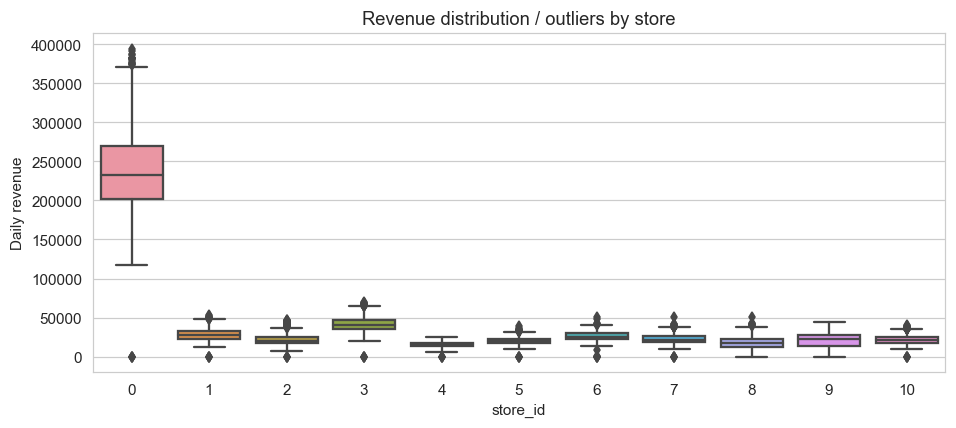

In [200]:
# -----------------------------------------------------------
# Revenue box-plot per store for outlier detection
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.boxplot(data=train_df, x="store_id", y="revenue")
plt.title("Revenue distribution / outliers by store")
plt.ylabel("Daily revenue")
plt.show()

#### ACF/PACF on log-transformed revenues

**Key Takeaways**:

- Weekly seasonality is dominant:

Regular spikes every 7 lags in the ACF (and corresponding seasonal spike in the PACF) confirm a strong 7-day cycle.
→ Include lag 7/14/21 features and set seasonal_period=7 in SARIMA/ETS.

- Short-range memory is modest:

PACF shows one large spike at lag 1, then drops sharply.
→ An AR(1) (plus seasonal AR(1)) is probably enough; ML models just need lag_1.

- Series are still non-stationary in level:

ACF decays slowly rather than cutting off, indicating trend.
→ Use first-differencing or let STL/Prophet remove the trend; keep a time index for tree/NN models.

- Pattern is consistent across hierarchy:

Store 0 (aggregate) and Store 3 (typical branch) look almost identical.
→ One global model with a store_id categorical can share the same seasonal features; no need for custom seasonality per store.

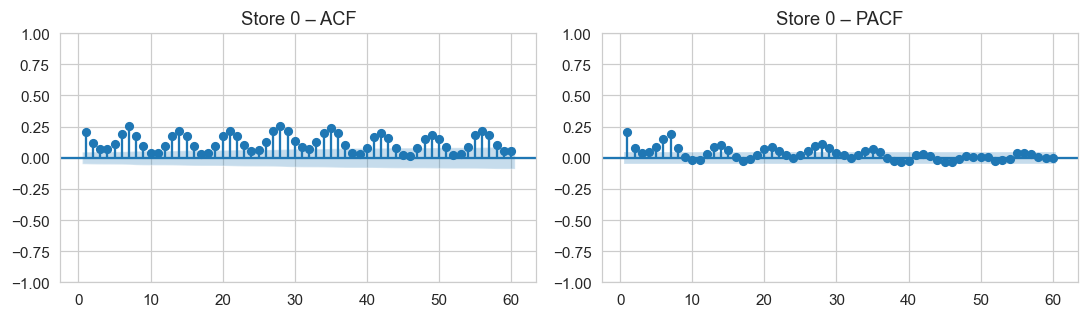

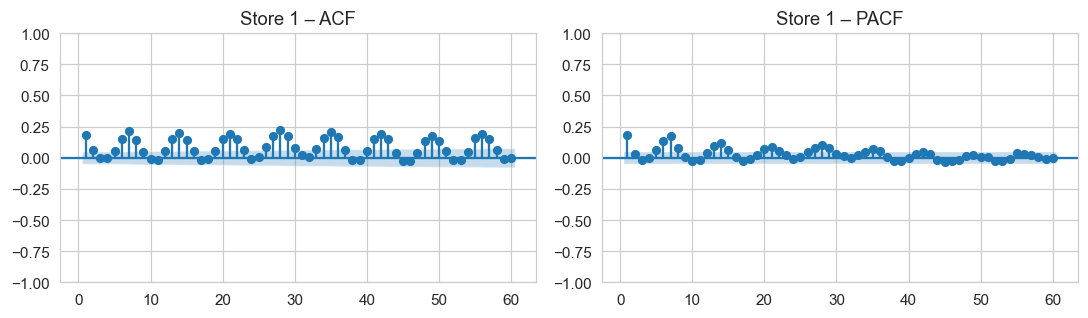

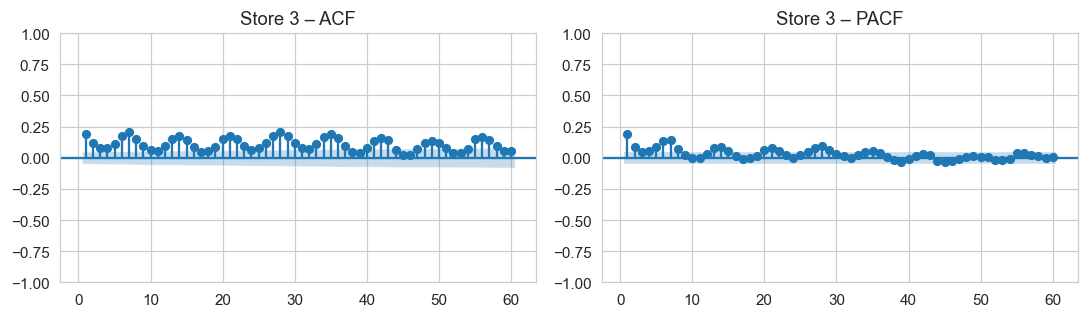

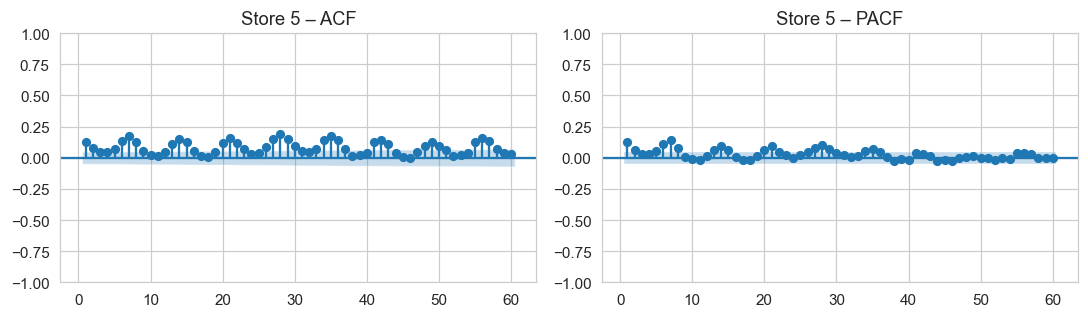

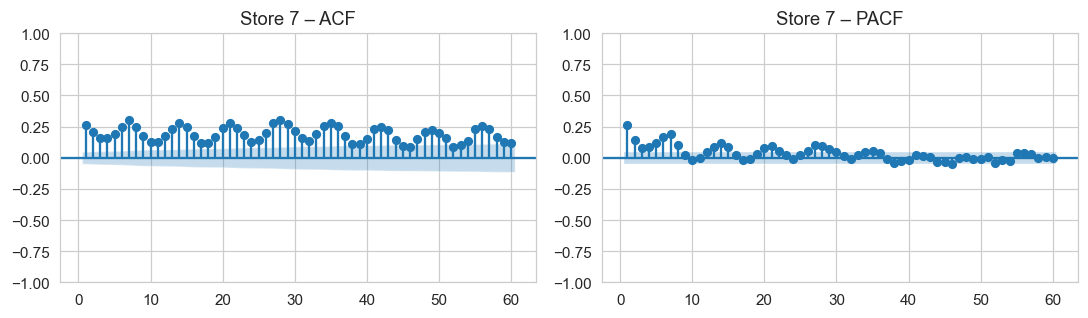

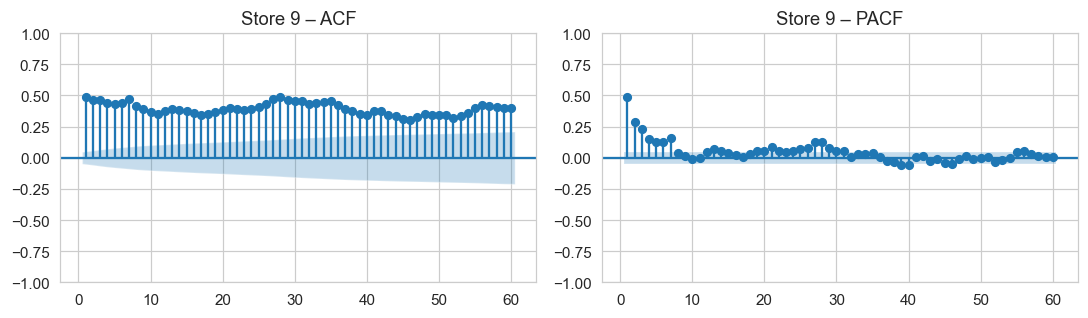

In [201]:
def acf_pacf_plots(store_id, lags=60):
    """Show ACF & PACF on log1p(revenue) for the selected store."""
    series = (
        full_df.query("store_id == @store_id")
               .sort_values("date")             # ensure true time order
               .set_index("date")["revenue"]    # keep zeros; only real NaNs are dropped
               .dropna()
               .pipe(np.log1p)
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(series,  lags=lags, zero=False, ax=ax[0])
    plot_pacf(series, lags=lags, zero=False, ax=ax[1])
    ax[0].set_title(f"Store {store_id} – ACF")
    ax[1].set_title(f"Store {store_id} – PACF")
    plt.tight_layout()
    plt.show()

# run on aggregate + several representative stores
for sid in [0, 1, 3, 5, 7, 9]:
    acf_pacf_plots(sid)

#### Seasonal–sub-series plots

- The bar charts validate the interpretations we drew from ACF/PACF:
    - dominant weekly cycle.
    - mild but present annual drift.
    - pattern shared across stores.

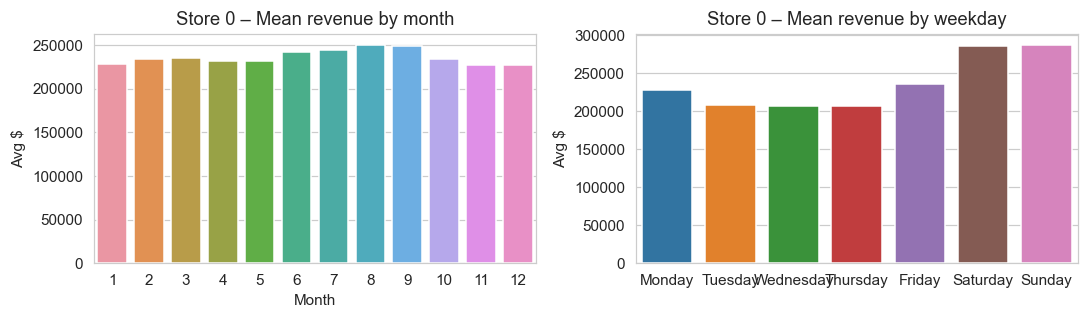

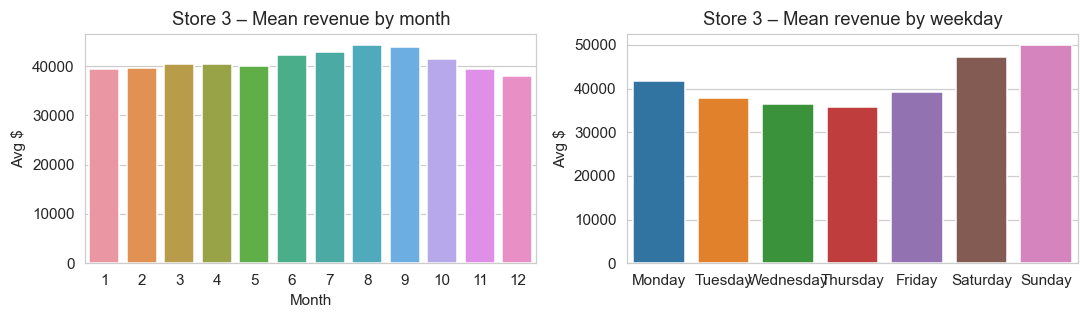

In [202]:
# choose a representative individual store (e.g. 3) and the aggregate (0)
TARGET_STORES = [0, 3]

for sid in TARGET_STORES:
    s = full_df.query("store_id == @sid")

    # ----- Month–of–year profile -------------------------------------------
    moy = (
        s.assign(month=s.date.dt.month)
         .groupby("month").revenue.mean()
    )

    # ----- Day-of-week profile --------------------------------------------
    dow = (
        s.assign(dow=s.date.dt.day_name())
         .groupby("dow").revenue.mean()
         .reindex(["Monday","Tuesday","Wednesday",
                   "Thursday","Friday","Saturday","Sunday"])
    )

    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.barplot(x=moy.index, y=moy.values, ax=ax[0])
    ax[0].set_title(f"Store {sid} – Mean revenue by month")
    ax[0].set_xlabel("Month");  ax[0].set_ylabel("Avg $")

    sns.barplot(x=dow.index, y=dow.values, ax=ax[1])
    ax[1].set_title(f"Store {sid} – Mean revenue by weekday")
    ax[1].set_xlabel("");       ax[1].set_ylabel("Avg $")
    plt.tight_layout(); plt.show()

#### Log 1 + p(revenue) histogram
we are doing it to:
1. Stabilises variance
2. Tame right-skew & outliers
3. Handle multiplicative effects naturally
4. Reduce heteroscedasticity in residuals
5. It is safe with zeros via log1p
6. Easy to invert for submission

- **Variance now tamed**:

After the log1p transform the bulk of points (stores 1-10) forms a neat bell-shaped bump ≈ 10 on the x-axis → modelling on log scale should give more stable gradients and a metric (RMSE) that isn’t dominated by extreme spikes.

- **Tiny spike at 0 = rare closure/outage days:**

Those exact-zero rows are < 0.3 % of the data; keep them as zeros and pass a binary is_zero_day flag. No special zero-inflated model needed.

- **Right-hand hump ≈ 12–13 comes from store 0 (aggregate) + holiday peaks:**

Confirms large scale gap between the all-stores series (~ 220 k dollars per day) and individual stores (~ 22 k dollars).

- **Modelling implication:**

- use store_id as a categorical feature (or train a separate model for store 0) so the learner can treat scales differently; otherwise the global loss may over-focus on store 0.

- **No intermittent-demand issue:**

Because virtually all days have positive sales, we don’t need Croston-type methods or zero-inflated objectives—standard Tweedie/Poisson or plain RMSE is fine.

- **Decision locked-in:**
-
log1p(revenue) will be our target for ML / DL models, with an inverse transform (expm1) right before submission.

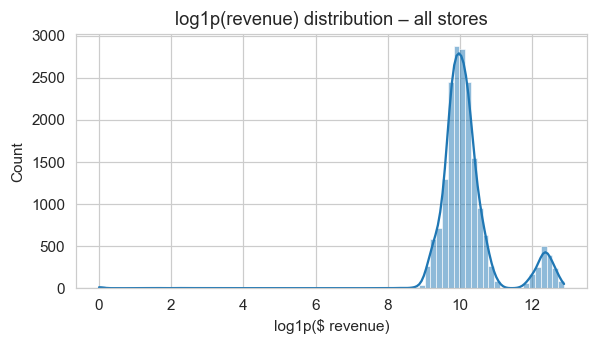

In [203]:
# ------------------------------------------------------------------
# Inspect log1p distribution to decide on variance stabilisation on all stores
# ------------------------------------------------------------------
plt.figure(figsize=(6,3))
sns.histplot(np.log1p(full_df.revenue), bins=80, kde=True)
plt.title("log1p(revenue) distribution – all stores")
plt.xlabel("log1p($ revenue)")
plt.show()

#### Per-store variance & skew table  (log1p + raw for comparison)

In [204]:
# ------------------------------------------------------------------
# Per-store variance & skew table  (log1p + raw for comparison)
# ------------------------------------------------------------------
var_skew_tbl = (
    full_df.assign(log_rev=lambda d: np.log1p(d.revenue))
           .groupby("store_id")
           .agg(raw_mean = ('revenue', 'mean'),
                raw_var  = ('revenue', 'var'),
                raw_skew = ('revenue', sc_stats.skew),
                log_mean = ('log_rev',  'mean'),
                log_var  = ('log_rev',  'var'),
                log_skew = ('log_rev',  sc_stats.skew))
           .round(2)
)
display(var_skew_tbl)

,raw_mean,raw_var,raw_skew,log_mean,log_var,log_skew
store_id,,,,,,
0,237057.45,2.984826e+09,0.15,12.33,0.20,-13.19
1,28756.90,5.954453e+07,0.39,10.21,0.32,-14.11
2,21393.61,3.408220e+07,0.97,9.92,0.18,-10.87
3,41134.34,8.537632e+07,0.08,10.58,0.23,-14.82
4,15469.16,1.186658e+07,-0.15,9.60,0.27,-14.94
5,20081.25,2.243485e+07,0.34,9.86,0.26,-14.81
6,26304.04,3.260776e+07,0.18,10.14,0.22,-15.08
7,22268.39,3.354563e+07,0.47,9.96,0.20,-11.48
8,18289.56,4.998661e+07,0.55,9.72,0.39,-8.83


#### STL decomposition (weekly seasonality)

- Trend panel – smooth upward slope across all stores ⇒ long-run growth; sudden dips match the rare outage/closure days.

- Seasonal (period = 7) – clean, sine-like weekly wave (peaks on Sat/Sun, trough mid-week); amplitude is stable over the 5 years.
→ captures the strong 7-day cycle already seen in ACF/PACF.

- Remainder / Residual – mostly white-noise cloud; big positive spike the day after an outage (catch-up sales).
Stationarity tests (ADF ≪ 0.05 & KPSS ≈ 0.10) confirm these residuals are stationary, so no extra differencing is needed for ARIMA-type baselines.

**Implications:**
1. Weekly dummies or lag-7 features are essential; yearly effects are mild and can be handled with simple month/Fourier terms.
2. Models should include a time-index or growth component for the monotonic trend.
3. Outage days can stay as zeros, but flagging them (is_zero_day) helps ML models learn the rebound that follows.

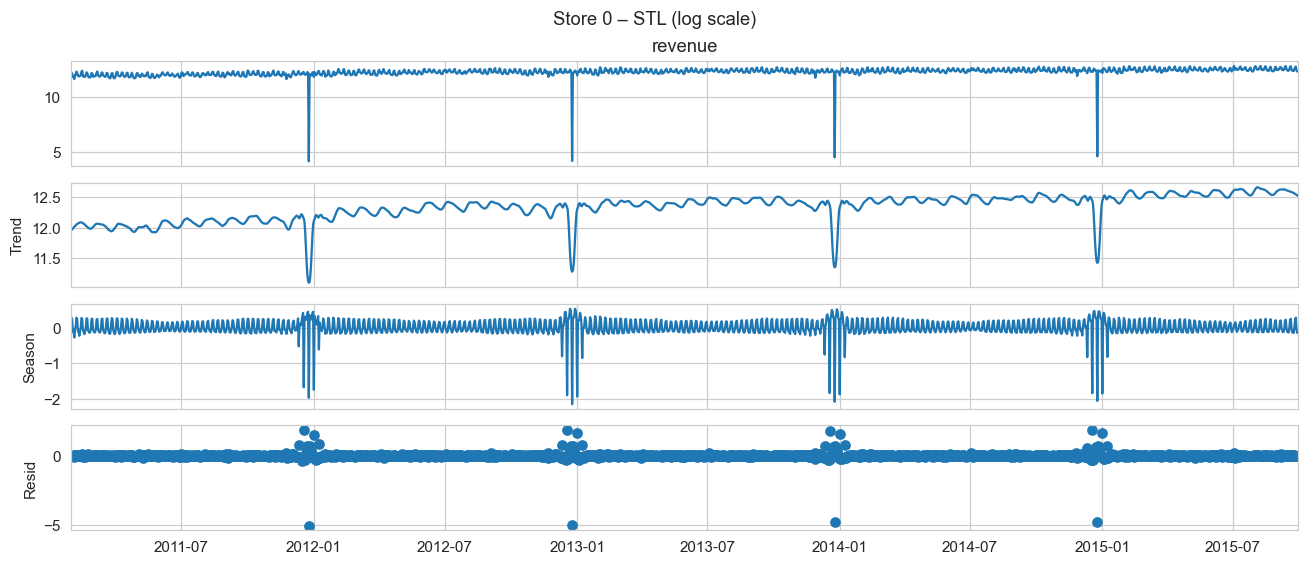

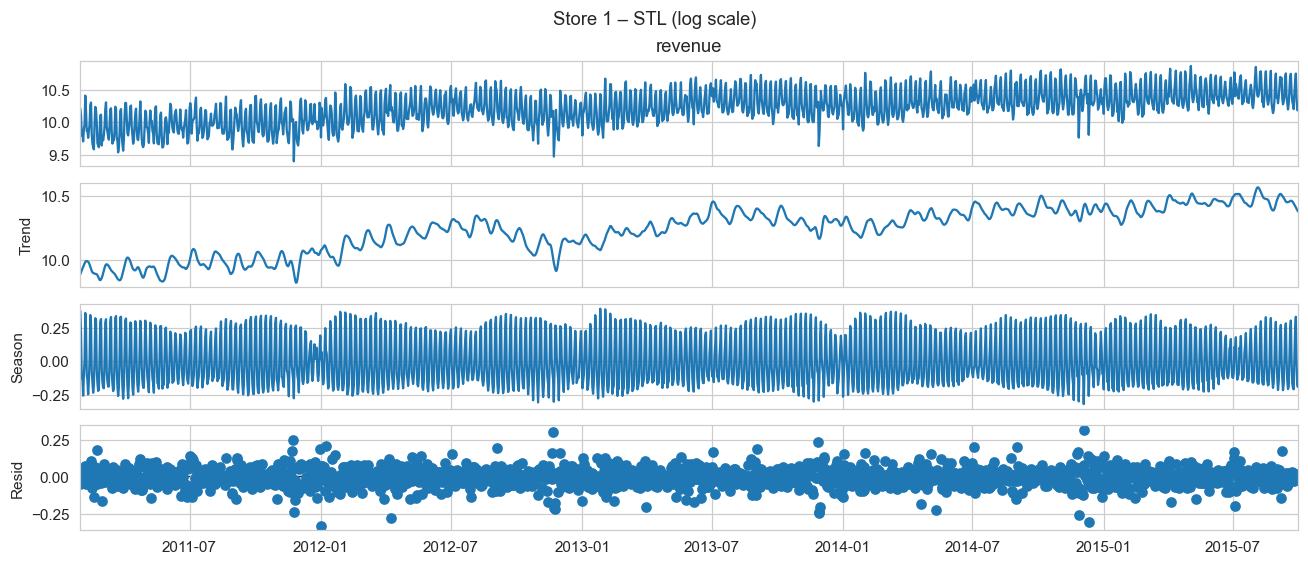

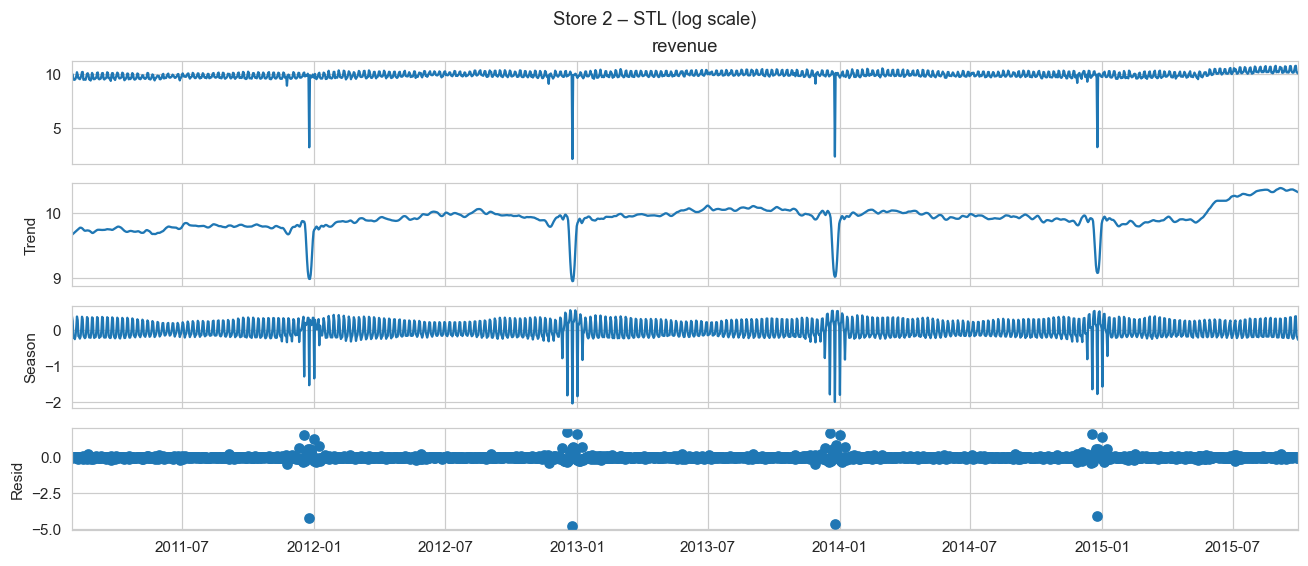

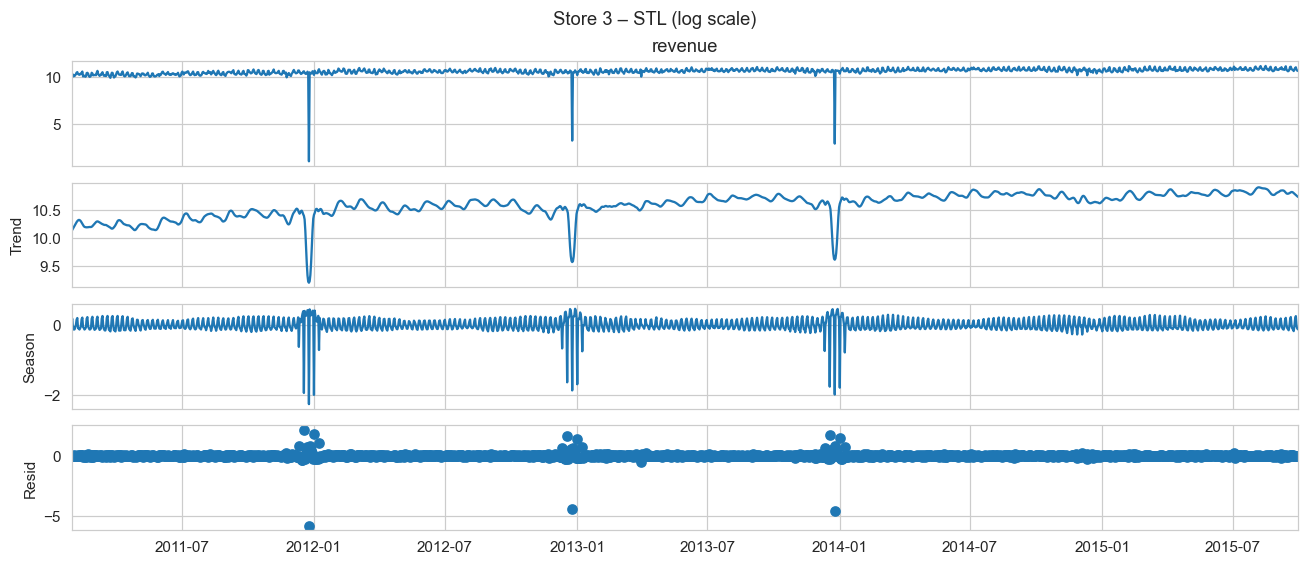

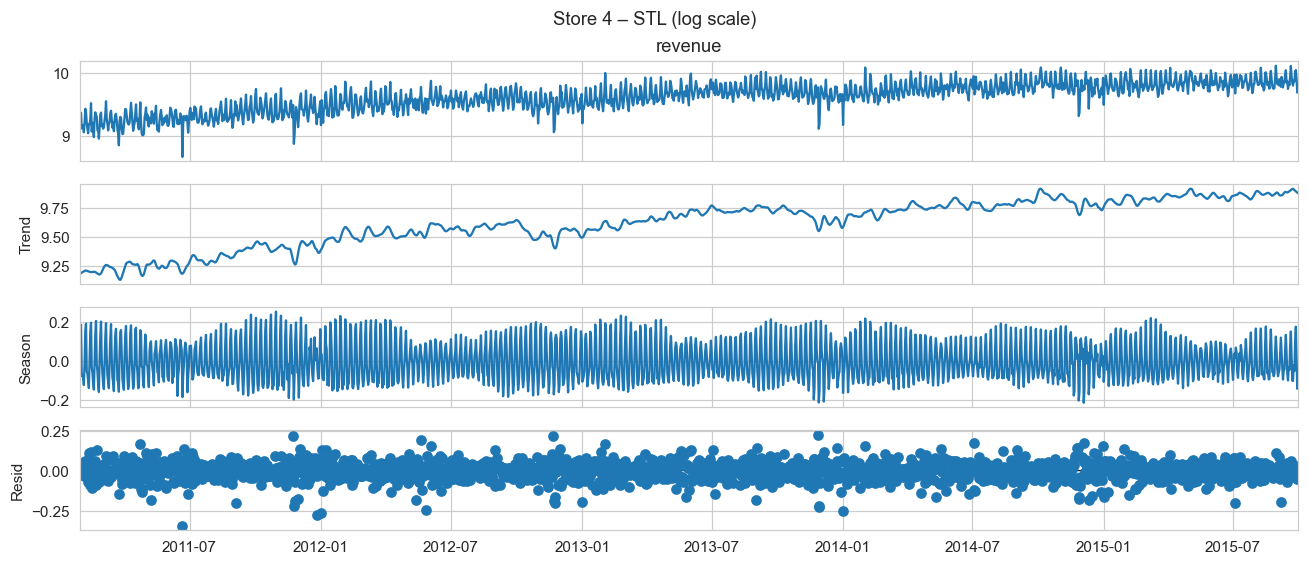

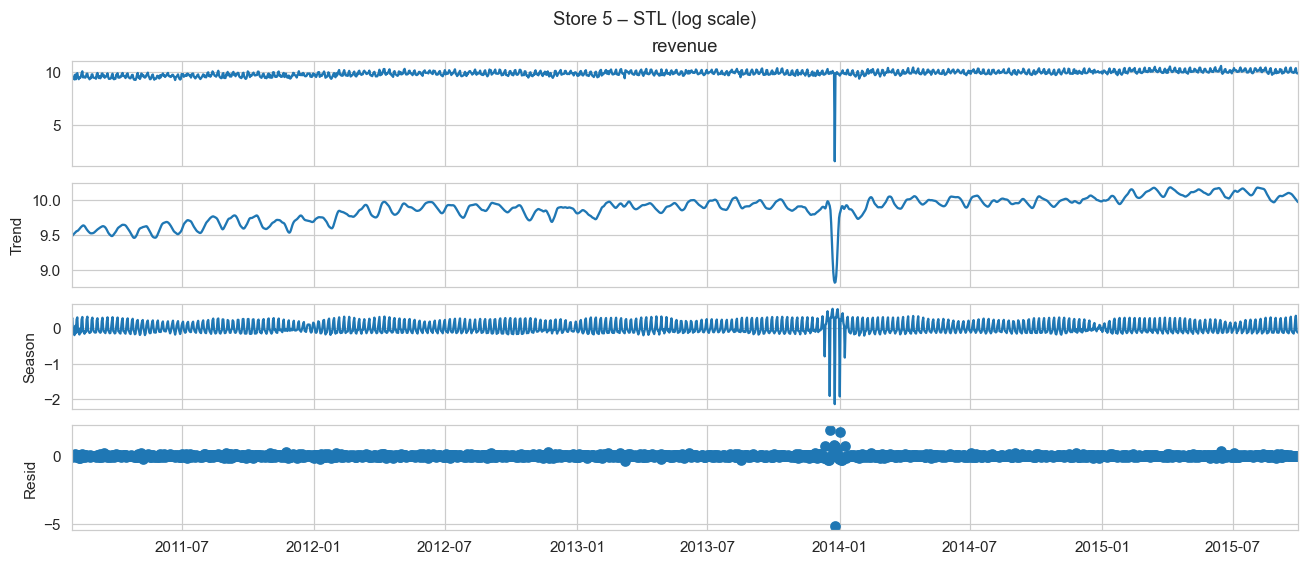

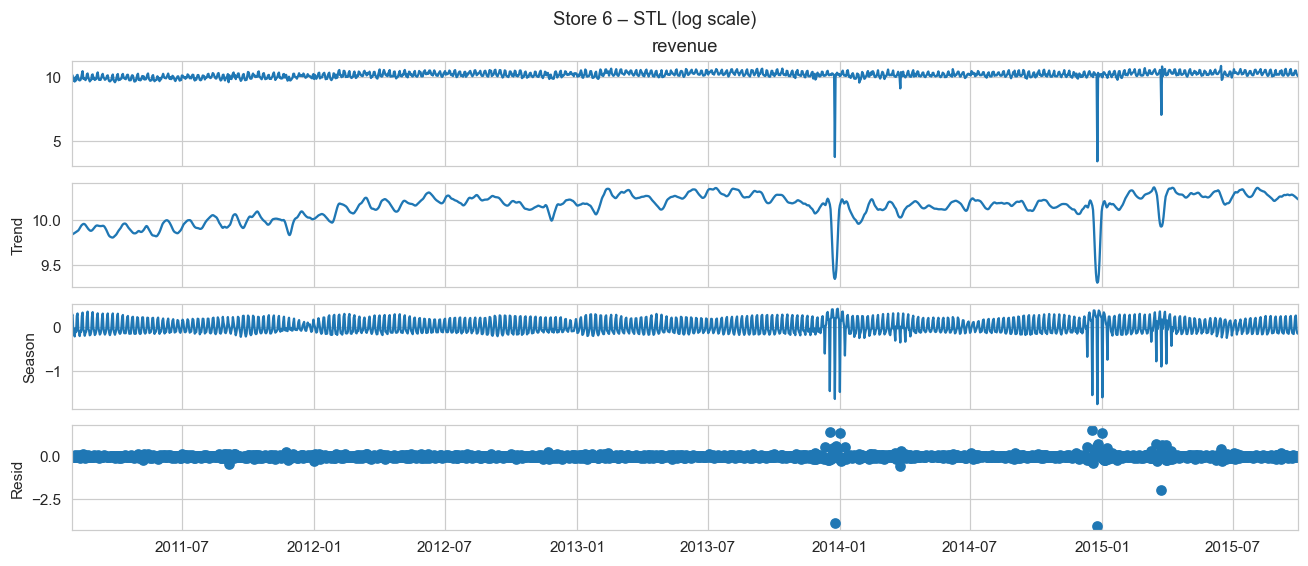

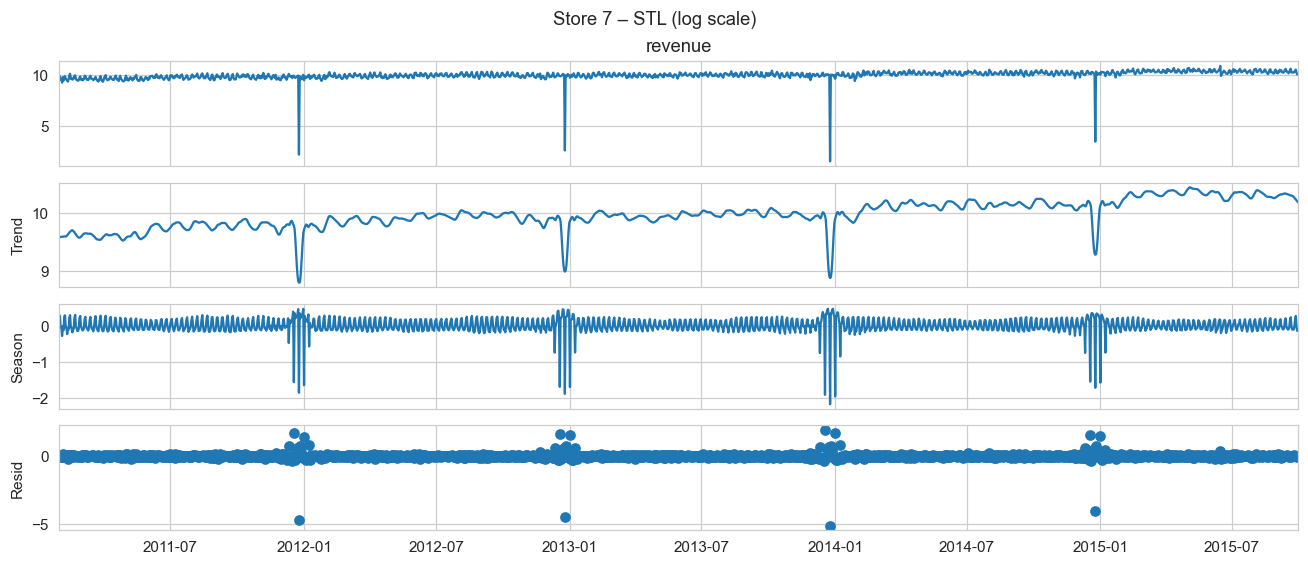

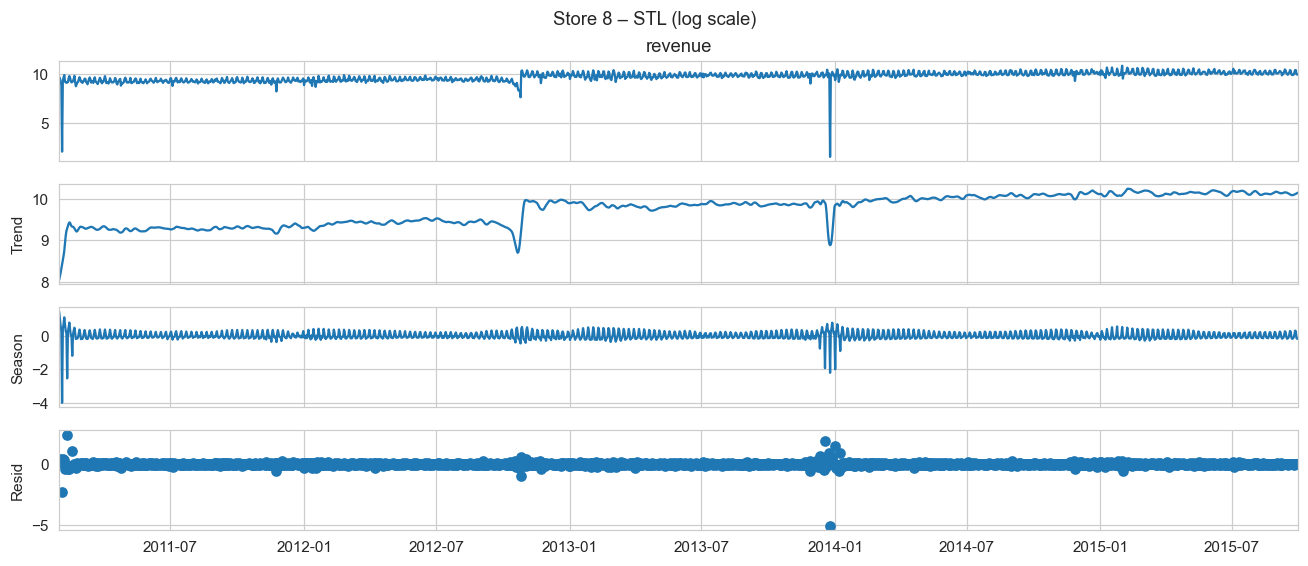

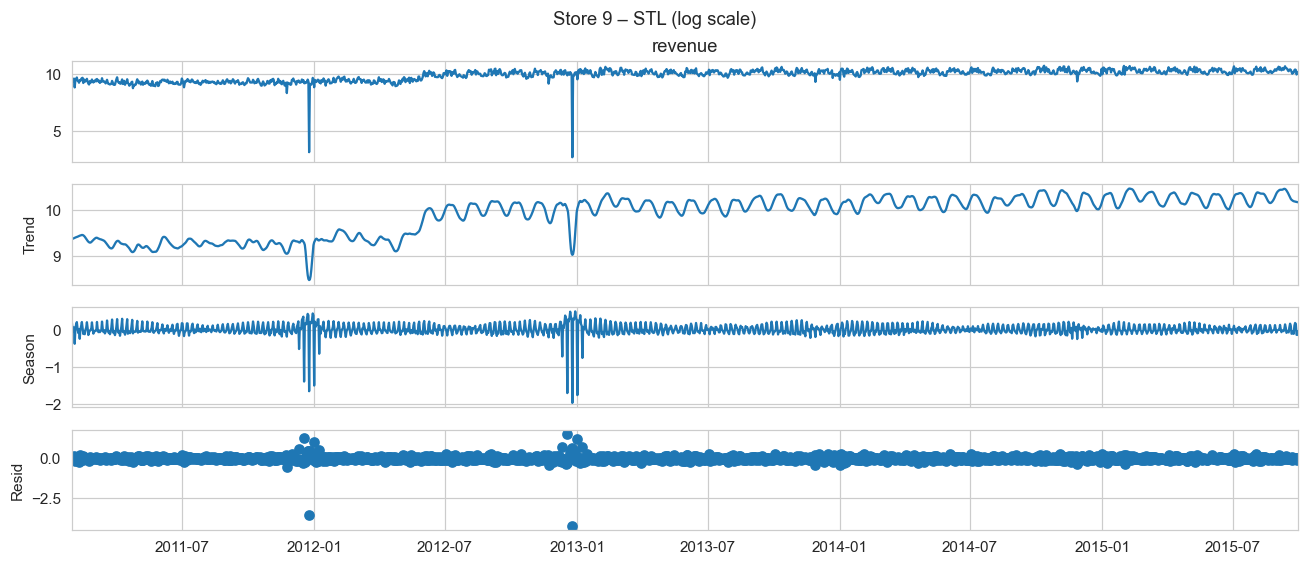

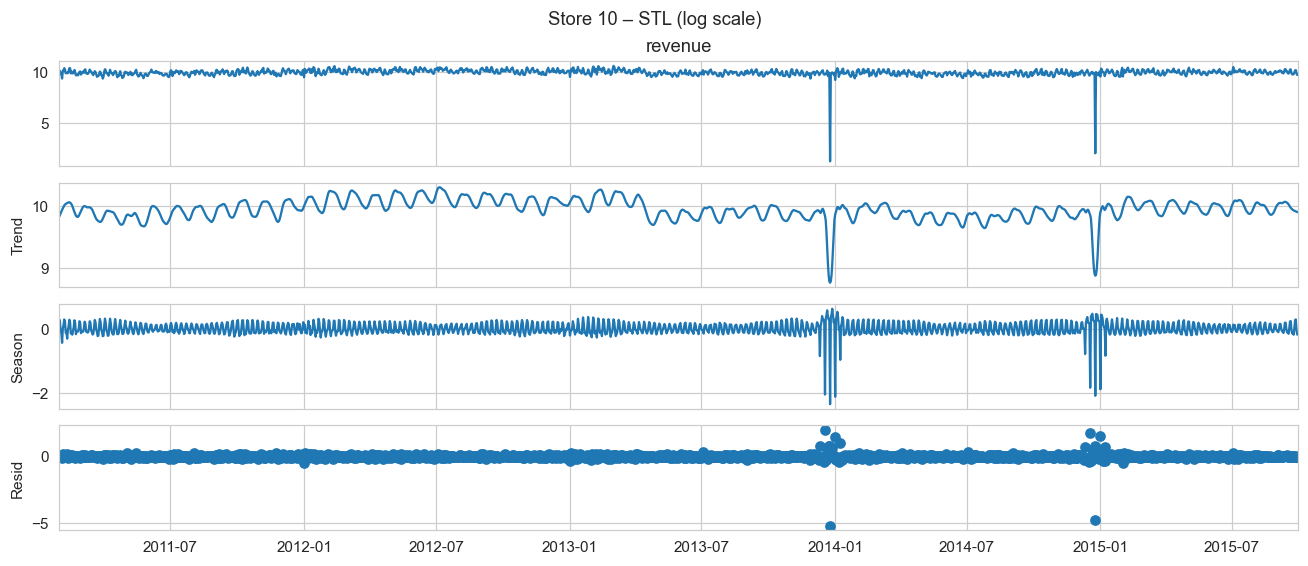

In [205]:
# ------------------------------------------------------------------
# STL decomposition (weekly seasonality)
# ------------------------------------------------------------------
def stl_decomp_plot(store_id, seasonal_len=7):
    series = (
        full_df.query("store_id == @store_id and revenue > 0")
               .set_index("date").revenue
               .pipe(np.log1p)
    )
    stl = STL(series, period=seasonal_len).fit()
    stl.plot()
    plt.suptitle(f"Store {store_id} – STL (log scale)", y=1.02)
    plt.show()
    return stl

# Run for all store IDs in one line
stl_models = {sid: stl_decomp_plot(sid) for sid in sorted(full_df.store_id.unique())}

#### Stationarity tests on STL residuals

- ADF-p < 0.05  → rejects unit-root (non-stationary) ⇒ *stationary*.
- KPSS-p > 0.05 → fails to reject that "Series is stationary around a constant mean" ⇒ cannot prove *non-stationary* ⇒ *stationary*.

**Conclusion:**

After removing trend + weekly seasonality with STL, the residuals of every store are stationary.

No additional differencing or detrending is required before fitting ARMA/SARIMA on those residuals, and machine-learning models can treat the deseasonalised, log-scaled series as stable noise.

In [206]:
# ------------------------------------------------------------------
# Stationarity tests on STL residuals
# ------------------------------------------------------------------

print("ADF & KPSS p-values for STL residuals  (expect ADF<0.05 & KPSS>0.05)")
for sid, stl_obj in stl_models.items():                 # stl_models came from the STL loop
    resid   = stl_obj.resid.dropna()
    adf_p   = adfuller(resid, autolag="AIC")[1]
    kpss_p  = kpss(resid, regression="c", nlags="auto")[1]
    print(f"store {sid:2d}  ADF p={adf_p:.2e}   KPSS p={kpss_p:.3f}")

ADF & KPSS p-values for STL residuals  (expect ADF<0.05 & KPSS>0.05)
store  0  ADF p=8.39e-30   KPSS p=0.100
store  1  ADF p=7.81e-29   KPSS p=0.100
store  2  ADF p=3.09e-30   KPSS p=0.100
store  3  ADF p=9.24e-30   KPSS p=0.100
store  4  ADF p=3.35e-29   KPSS p=0.100
store  5  ADF p=1.49e-29   KPSS p=0.100
store  6  ADF p=4.58e-30   KPSS p=0.100
store  7  ADF p=7.90e-30   KPSS p=0.100
store  8  ADF p=1.59e-28   KPSS p=0.100
store  9  ADF p=5.41e-30   KPSS p=0.100
store 10  ADF p=5.64e-30   KPSS p=0.100


#### Lag-28 PACF check
**Goal:** see whether a 28-day (4-week) memory spike exists. In retail datasets this often shows up because many promotions, payroll cycles, and inventory orders repeat every four weeks.

**Conclusion:**
1. No compelling evidence to require lag_28 as a core feature.
    - For ML models it’s cheap to include and may add a sliver of signal—feel free to add it with low priority.
    - For statistical baselines (SARIMA/ETS) stick with the weekly seasonality only.

<Figure size 880x330 with 0 Axes>

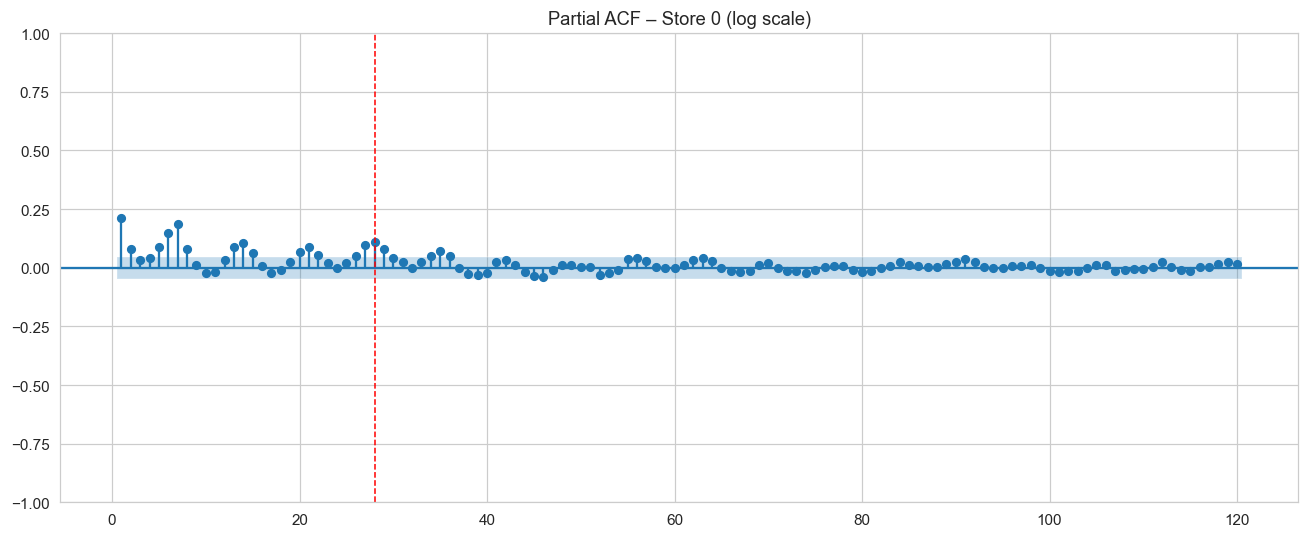

In [207]:
# use the aggregate series so the spike is visible even if it’s faint in one store
series_0 = (
    full_df.query("store_id == 0")
           .set_index("date").revenue
           .pipe(np.log1p)
)
#
plt.figure(figsize=(8,3))
plot_pacf(series_0, lags=120, zero=False, alpha=0.05)  # show first 120 lags
plt.axvline(28, color="red", ls="--", lw=1)            # highlight lag-28
plt.title("Partial ACF – Store 0 (log scale)")
plt.tight_layout()
plt.show()